In [1]:
import numpy as np
from fish.image.vol import get_stack_dims, get_stack_data, proj_plot, get_metadata
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

## Define some useful functions

In [90]:
def filt(cutoff, btype='low', order=6):
    # generate a bessel filter
    from scipy.signal import bessel, filtfilt
    b, a = bessel(order, cutoff, btype=btype)
    return lambda v: filtfilt(b,a,v)

def stack_loader(fname, dims):
    # load a .stack file, return it as a numpy array
    from numpy import fromfile
    data = fromfile(fname, dtype='uint16').reshape(dims)
    return data

def get_rect(coords):
    # convert a pair of slice objects into the corresponding patch object
    from matplotlib.patches import Rectangle
    x_start = coords[0].start
    y_start = coords[1].start
    
    x_stop = coords[0].stop
    y_stop = coords[1].stop
    return Rectangle((x_start, y_start), x_stop-x_start, y_stop-y_start)

def prepare_images(v, ds):
    # median filter, then uniform filter, then downsample in x,y
    median_size = (1,3,3)
    uniform_size = (1, ds, ds)
    from scipy.ndimage.filters import median_filter, uniform_filter
    medfilt = median_filter(v, size=median_size)
    unifilt = uniform_filter(v, size=uniform_size)[:,::ds,::ds]
    return unifilt

def rescale(v, in_range, out_range):    
    # Rescale intensity values of data, e.g. to convert from floating point to integer datatype
    in_ptp = in_range[1] - in_range[0]
    out_ptp = out_range[1] - out_range[0]    
    rescaled = (((v - in_range[0]) * out_ptp) / in_ptp) + out_range[0]        
    return rescaled

def upsample_volume(v, roi, ds_yx):
        # upsample a volume in x and y
        from numpy import zeros
        from scipy.interpolate import RectBivariateSpline
        
        output = zeros((v.shape[0], roi_yx[0].stop - roi_yx[0].start, roi_yx[1].stop - roi_yx[1].start))
        
        y_ds,x_ds = np.arange(roi_yx[0].start, roi_yx[0].stop, ds_yx), np.arange(roi_yx[1].start, roi_yx[1].stop, ds_yx)
        y_full, x_full = np.arange(y_ds[0], y_ds[-1] + ds_yx), np.arange(x_ds[0], x_ds[-1] + ds_yx)
        
        for ind, plane in enumerate(v):
            output[ind] = RectBivariateSpline(y_ds,x_ds, plane)(y_full, x_full)
        return output

 ## Set experiment parameters 
 Some of these (like the dimensions) should be inferred programmatically 

In [5]:
# Directory containing raw images
base_dir = '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/chen/CW_17_03_15/L1-561nm-20min_20170315_171611/'

# Dimensions of each image
dims = (45, 980, 1120)

# Sampling rate of the imaging, in Hz
fs_im = 3

# Range of images to process, e.g. for excluding initial timepoints
plr_t = slice(1000, 2000)

# Width of sliding window (in samples) used for dff estimation
dff_window =  100 * fs_im

In [6]:
fnames = glob(base_dir + '*TM*.stack')
fnames.sort()
fnames = fnames[plr_t]
print(len(fnames))

1000


In [7]:
sample = stack_loader(fnames[-1], dims)
print(sample.shape)

(45, 980, 1120)


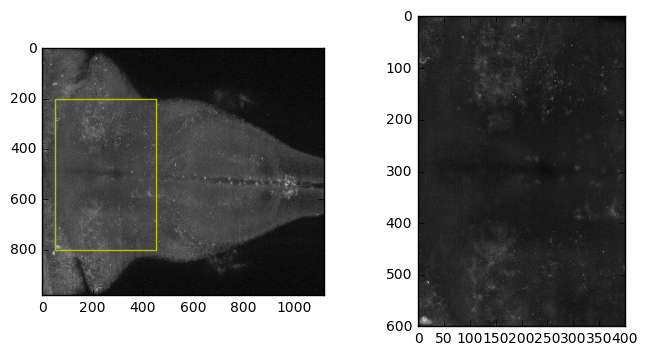

In [8]:
nr = 1
nc = 2
fig, axs = plt.subplots(nrows = nr, ncols=nc, figsize=(4 * nc, 4))
axs[0].imshow(np.log(sample.max(0)), cmap='gray')
roi_yx = (slice(200, 800), slice(50, 450))
rect = get_rect(roi_yx[::-1])
rect.set_fill(False)
rect.set_edgecolor('y')
axs[0].add_patch(rect)
axs[1].imshow(sample.max(0)[roi_yx], cmap='gray')

## Load data and spatially filter

In [16]:
%%time
import thunder as td
ims = td.images.fromlist(fnames, accessor=lambda v: stack_loader(v, dims), npartitions=len(fnames), engine=sc)

ds_yx = 4
ims = ims[:, :, roi_yx[0], roi_yx[1]].map(lambda v: prepare_images(v, ds_yx))
print(ims.shape)

(1000, 45, 150, 100)
CPU times: user 1.53 s, sys: 129 ms, total: 1.66 s
Wall time: 2.78 s


## Calculate local correlation

In [17]:
%%time
locorr = ims.localcorr(size=2)

CPU times: user 2.24 s, sys: 309 ms, total: 2.55 s
Wall time: 1min 7s


In [77]:
upsampled = upsample_volume(locorr, roi_yx, ds_yx)
tmp = np.zeros(sample.shape)
tmp[:,roi_yx[0], roi_yx[1]] = upsampled

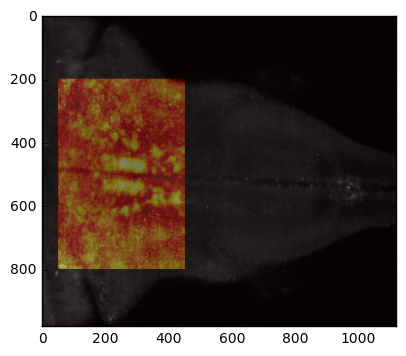

In [109]:
plt.imshow(sample.std(0), cmap='gray', alpha=1)
plt.imshow(tmp.std(0), cmap='hot', alpha = .4)

## Calculate dff, return as a local array

In [22]:
sub_vol = ims[0:1000].toseries().normalize(method = 'window', window=dff_window).astype('float32')
sub_vol = sub_vol.toarray()
sub_vol = np.rollaxis(sub_vol, -1, 0)

In [31]:
# todo: save dff volume to disk or analyze it here

In [20]:
%%time

from fish.image.alignment import estimate_translation
do_registration = True

# Load a template image for registration
ref_range = (len(fnames) // 2) + np.arange(-5,5)

ref = td.images.fromlist(np.array(fnames)[ref_range], accessor=lambda v: stack_loader(v, dims)).mean().toarray().astype('float32')
ref = prepare_images(ref, ds_yx)    

if do_registration:
    reg = ims.map(lambda v: estimate_translation(ref.max(0), v.max(0))).toarray()
    
affs = np.array([r.affine for r in reg])
#np.save(base_dir + 'regparams_affine.npy', affs)

Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 1000]
CPU times: user 15.5 s, sys: 1.35 s, total: 16.9 s
Wall time: 4min 19s


# Visualize registration results

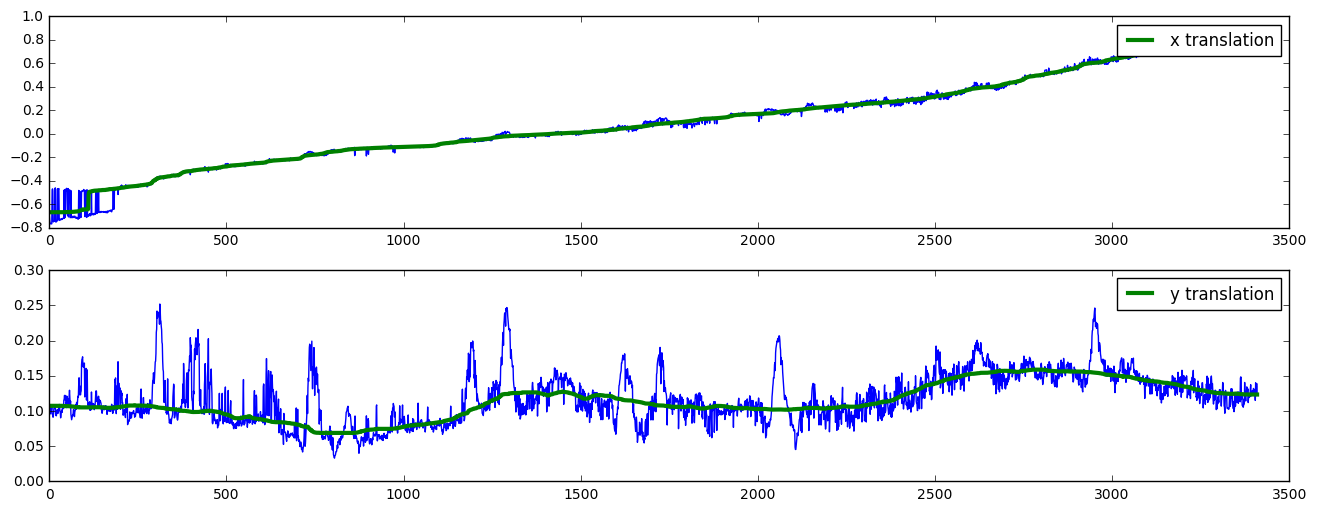

In [21]:
from scipy.ndimage.filters import median_filter
fig, axs = plt.subplots(nrows=2, figsize=(16,6))
x_trans_raw = affs[:, -2, -1]
y_trans_raw = affs[:, 0, -1]
x_trans = median_filter(x_trans_raw, size=400)
y_trans = median_filter(y_trans_raw, size=400)
z_trans = np.zeros(x_trans.shape)
trans = np.vstack([z_trans, y_trans, x_trans])

axs[0].plot(x_trans_raw)
axs[0].plot(x_trans, linewidth=3, label = 'x translation')
axs[0].legend()
axs[1].plot(y_trans_raw)
axs[1].plot(y_trans, linewidth=3, label = 'y translation')
axs[1].legend()

##  Apply registration

In [22]:
from scipy.ndimage.interpolation import shift
# important to apply -1 * translation
if not mx_proj:
    ims_registered = ims.map(lambda v: shift(v[1], -trans[:, v[0][0]], cval=thr + 1), with_keys=True)
else:    
    ims_registered = ims.map(lambda v: shift(v[1], -trans[1:, v[0][0]], cval=thr + 1), with_keys=True)

In [23]:
%%time
ser = ims.toseries().normalize(method = 'window', window=dff_window).astype('float32').cache()

# apply low pass filter, then downsample in time
ds_t = 4
ser = ser.map(lambda v: filt(.2)(v)[::ds_t])
ser = ser.repartition(2048)
ser.count()

CPU times: user 970 ms, sys: 283 ms, total: 1.25 s
Wall time: 5min 14s


In [16]:
ser.shape

(45, 150, 100, 778)

In [17]:
%%time
import factorization as fct
ica_results = fct.ICA(k=10,k_pca=20).fit(ser)

CPU times: user 2min 2s, sys: 7.36 s, total: 2min 9s
Wall time: 3min 12s


In [18]:
[print(i.shape) for i in ica_results];

(45, 150, 100, 10)
(10, 778)


[None, None]

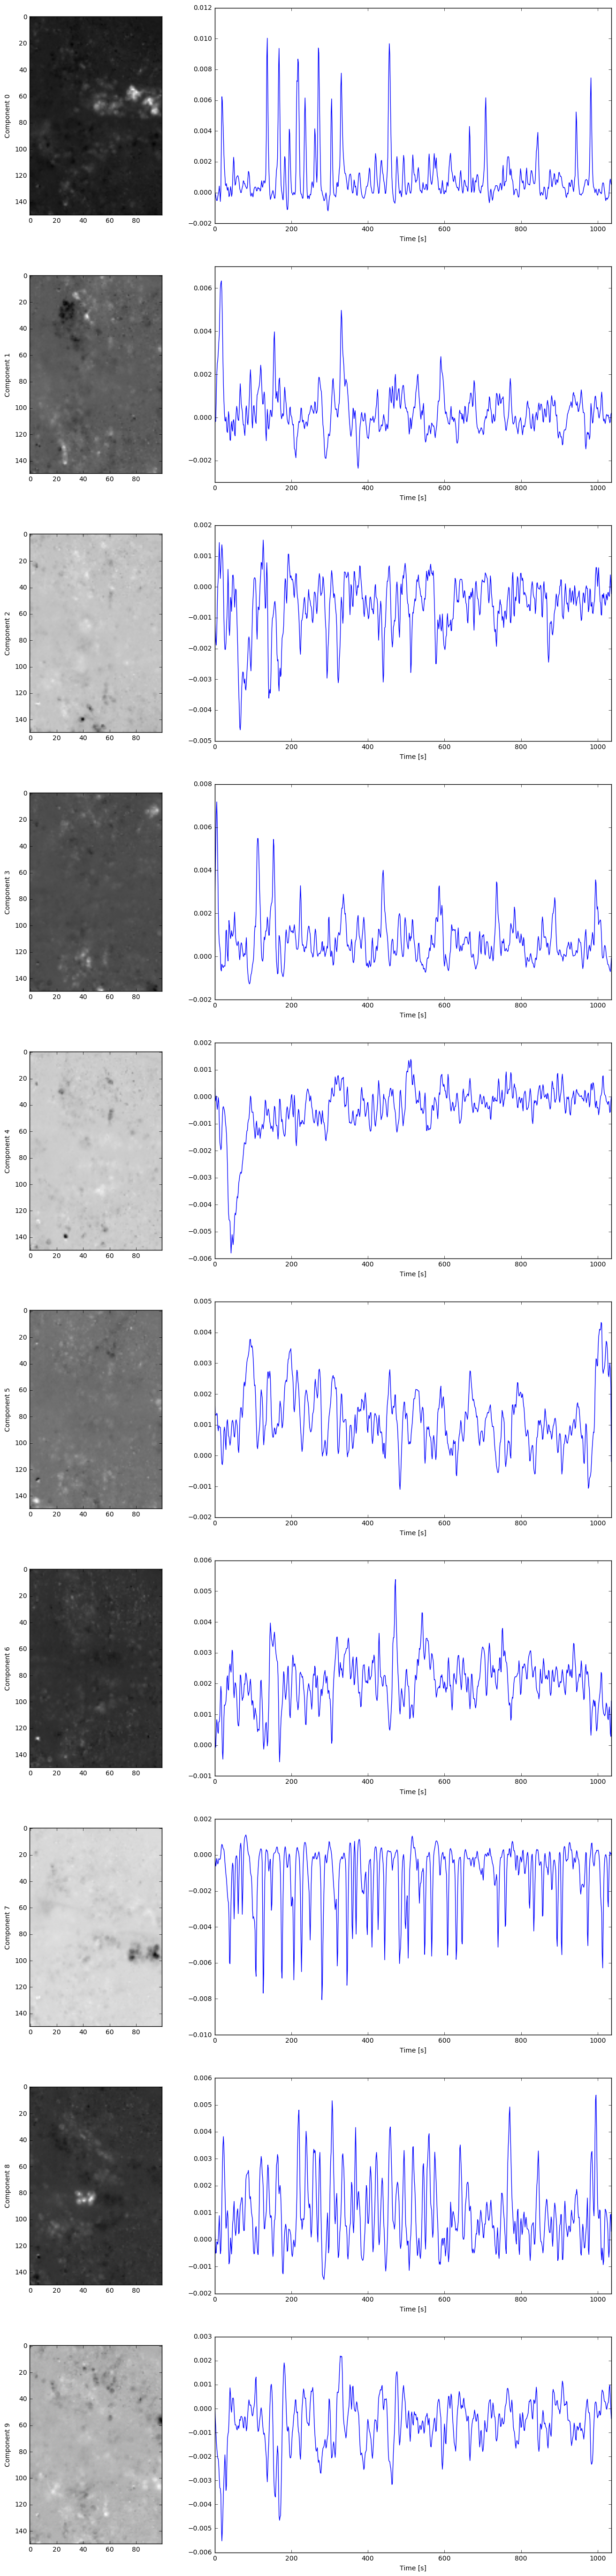

In [19]:
to_plot = range(ica_results[1].shape[0])

nr = len(to_plot)
nc = 2

fig, axs = plt.subplots(nr, nc, figsize=(8 * nc, 7 * nr), gridspec_kw={'width_ratios' : (1,3)})
for ind, comp in enumerate(to_plot):

    try:
        ax_im = axs[ind][0]
        ax_ts = axs[ind][1]
    except TypeError:
        ax_im = axs[0]
        ax_ts = axs[1]
        
    ica_map = ica_results[0].T[comp].T
    ica_ts = ica_results[1][comp]
    plr_ts = np.arange(len(ica_ts))
    plr_s = plr_ts * fs_im * ds_t

    if ica_map.ndim > 2:
        ax_im.imshow(ica_map.max(0) + ica_map.min(0), cmap='gray')
    else:
        ax_im.imshow(ica_map, cmap='gray')    
    
    ax_im.set_ylabel('Component {0}'.format(comp))
    ax_ts.plot(plr_s, ica_ts[plr_ts])
    ax_ts.set_xlim(plr_s[0], plr_s[-1])
    ax_ts.set_xlabel('Time [s]')

## Save dff max projection to disk

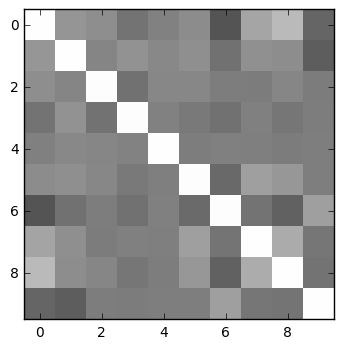

In [20]:
plt.imshow(np.corrcoef(ica_results[1]), interpolation='None', cmap='gray', clim = [-1,1])